In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [ ]:
%cd /content/drive/MyDrive/Storma/machine-learning-challenge

### Install Packages

In [ ]:
!pip3 install pycocotools

# !pip3 install nb_black
# %load_ext lab_black

!pip3 install black[jupyter]
!black "/content/drive/MyDrive/Storma/machine-learning-challenge/coco2yolo.ipynb"

### Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from pycocotools.coco import COCO
from IPython.display import display  # to display images
import random
import skimage.io as io
import torch

torch.version.cuda
import pylab

pylab.rcParams["figure.figsize"] = (12, 14)  # Import Libraries

%matplotlib inline

**Coco**:
- Format `[x_min, y_min, width, height]`

The coordinates (x_min, y_min) are the top-left corner along with the width and height of the bounding box.

**Pascal_VOC** :
- Format: `[x_min, y_min, x_max, y_max]`

x_min and y_min are coordinates of the top-left corner and x_max and y_max are coordinates of bottom-right corner of the bounding box.

**Yolo**:
- Format: `[x_center, y_center, width, height]`

**x_center and y_center are the normalized coordinates of the centre of the bounding box. The width and height are the normalized length. To convert YOLO in Coco or Pascal or vice versa it is important to have the size of the image to calculate the normalization.**

### Load and Explore COCO annotations

In [1]:
import json
import os
import glob
import shutil

data_folder = "../data"  #os.path.join(os.getcwd(), "data")
coco_images_folder = os.path.join(
    data_folder,
    "coco/images/test/frames",
)
coco_json_file = os.path.join(
    data_folder,
    "coco/annotations/instances_test.json",
)


coco_images_folder,coco_json_file

('../data/coco/images/test/frames',
 '../data/coco/annotations/instances_test.json')

In [4]:
# Load COCO annotations
coco_annotation = COCO(annotation_file=coco_json_file)

# Get Category IDs.
cat_ids = coco_annotation.getCatIds()
print(f"Number of Unique Categories: {len(cat_ids)}")
print("Category IDs:", cat_ids)  # The IDs are not necessarily consecutive.

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of Unique Categories: 2
Category IDs: [1, 2]


In [5]:
# Get all categories.
cats = coco_annotation.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print("Categories Names:", cat_names)

# Category ID -> Category Name.
query_id = cat_ids[0]
query_annotation = coco_annotation.loadCats([query_id])[0]
query_name = query_annotation["name"]
query_supercategory = query_annotation["supercategory"]
print(
    f"Category ID: {query_id}, Category Name: {query_name}, Supercategory: {query_supercategory}"
)

# Category Name -> Category ID.
query_name = cat_names[0]
query_id = coco_annotation.getCatIds(catNms=[query_name])[0]
print(f"Category Name: {query_name}, Category ID: {query_id}")

# Get the ID of all the images containing the object of the category.
img_ids = coco_annotation.getImgIds(catIds=[query_id])
print(f"Number of Images Containing {query_name}: {len(img_ids)}")

Categories Names: ['bolt', 'nut']
Category ID: 1, Category Name: bolt, Supercategory: none
Category Name: bolt, Category ID: 1
Number of Images Containing bolt: 1564


Image Details: {'file_name': '0985.jpg', 'width': 640, 'height': 640, 'id': 986}
Annotation for Image ID 986: [{'image_id': 986, 'category_id': 1, 'segmentation': [], 'bbox': [65.0, 0.0, 77.0, 25.0], 'area': 1925.0, 'iscrowd': 0, 'id': 2086, 'track_id': 49}]


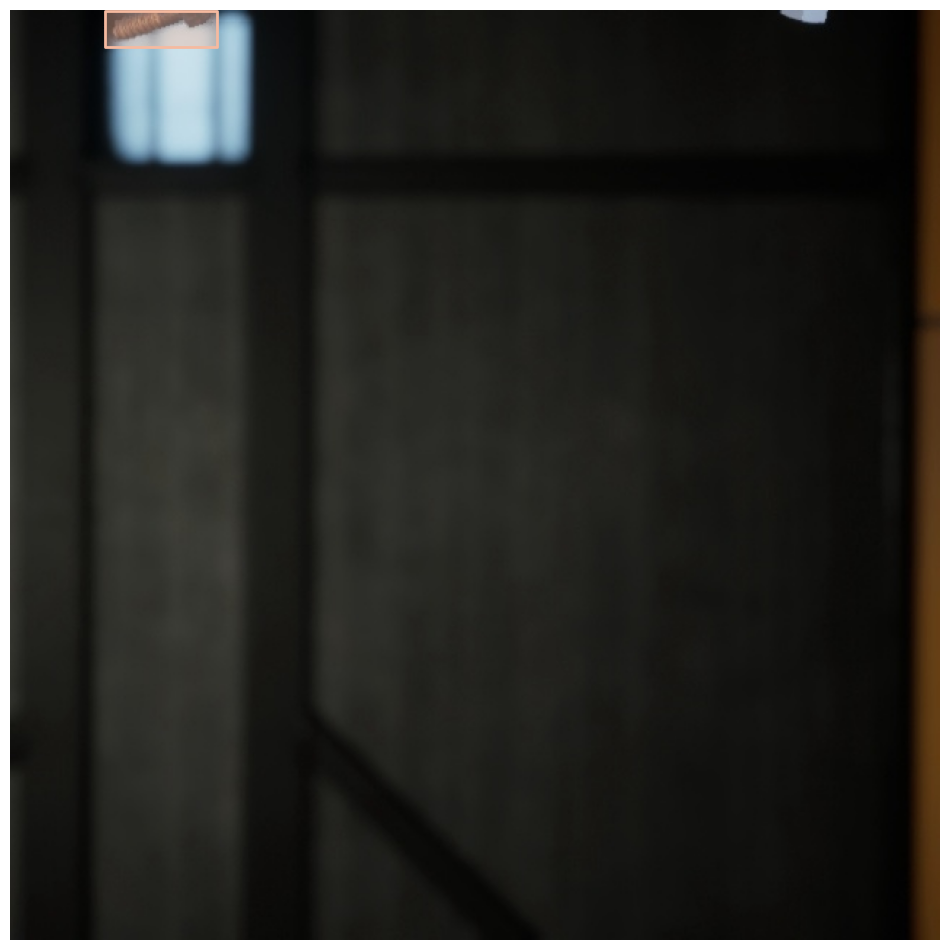

In [6]:
# Pick a random image id
img_id = random.choice(img_ids)

# Load the image
img_info = coco_annotation.loadImgs([img_id])[0]
print("Image Details:", img_info)

# Load image.
img = io.imread(os.path.join(coco_images_folder, img_info["file_name"]))

# Get all the annotations for specific image.
ann_ids = coco_annotation.getAnnIds(imgIds=img_id, iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)
print(f"Annotation for Image ID {img_id}:", anns)

# Display Image
plt.imshow(img)
plt.axis("off")
coco_annotation.showAnns(anns, draw_bbox=True)

### Convert COCO to YOLO data format

In [7]:
class COCO_PARSER:
    def __init__(self, json_file, output_dir, classes_file):
        self.json_file, self.output_dir, self.classes_file = self._check_file_and_dir(
            json_file, output_dir, classes_file
        )
        self.labels = json.load(open(self.json_file, "r", encoding="utf-8"))
        self.coco_id_name_map = self._categories()
        self.coco_name_list = list(self.coco_id_name_map.values())
        print("total images", len(self.labels["images"]))
        print("total categories", len(self.labels["categories"]))
        print("total labels", len(self.labels["annotations"]))

    def _check_file_and_dir(self, json_file, output_dir, classes_file):
        if not os.path.exists(json_file):
            raise ValueError("file not found")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        return json_file, output_dir, classes_file

    def _categories(self):
        categories = {}
        for cls in self.labels["categories"]:
            categories[cls["id"]] = cls["name"]
        return categories

    def _load_images_info(self):
        images_info = {}
        for image in self.labels["images"]:
            id = image["id"]
            file_name = image["file_name"]
            if file_name.find("\\") > -1:
                file_name = file_name[file_name.index("\\") + 1 :]
            w = image["width"]
            h = image["height"]
            images_info[id] = (file_name, w, h)

        return images_info

    def _bbox_2_yolo(self, bbox, img_width, img_height):
        ann_bbox_xmin, ann_bbox_ymin, ann_bbox_width, ann_bbox_height = (
            bbox[0],
            bbox[1],
            bbox[2],
            bbox[3],
        )
        center_x_scaled = (ann_bbox_xmin + (ann_bbox_width * 0.5)) / img_width
        center_y_scaled = (ann_bbox_ymin + (ann_bbox_height * 0.5)) / img_height
        width_scaled = ann_bbox_width / img_width
        height_scaled = ann_bbox_height / img_height

        return center_x_scaled, center_y_scaled, width_scaled, height_scaled

    def _convert_anno(self, images_info):
        anno_dict = dict()
        for anno in self.labels["annotations"]:
            image_id = anno["image_id"]
            category_id = anno["category_id"]
            bbox = anno["bbox"]
            segmentation = anno["segmentation"]

            image_info = images_info.get(image_id)
            image_name = image_info[0]
            img_w = image_info[1]
            img_h = image_info[2]

            new_anno = self._bbox_2_yolo(bbox, img_w, img_h)

            anno_info = (image_name, category_id, new_anno)
            anno_infos = anno_dict.get(image_id)

            if not anno_infos:
                anno_dict[image_id] = [anno_info]
            else:
                anno_infos.append(anno_info)
                anno_dict[image_id] = anno_infos
        return anno_dict

    def _save_classes(self, classes_file):
        sorted_classes = list(
            map(
                lambda x: x["name"],
                sorted(self.labels["categories"], key=lambda x: x["id"]),
            )
        )
        print("coco names", sorted_classes)
        with open(classes_file, "w", encoding="utf-8") as f:
            for cls in sorted_classes:
                f.write(cls + "\n")
        f.close()

    def _save_txt(self, anno_dict):
        for k, v in anno_dict.items():
            file_name = v[0][0].split(".")[0] + ".txt"
            with open(
                os.path.join(self.output_dir, file_name), "w", encoding="utf-8"
            ) as f:
                print(k, v)
                for obj in v:
                    cat_name = self.coco_id_name_map.get(obj[1])
                    category_id = self.coco_name_list.index(cat_name)
                    line = ""
                    box = ["{:.4f}".format(x) for x in obj[2]]
                    box = " ".join(box)
                    line = str(category_id) + " " + box
                    f.write(line + "\n")

    def convert_coco(self):
        print("[INFO] Loading image info...")
        images_info = self._load_images_info()
        print(f"[INFO] Loading done, total images {len(images_info)}")

        print("[INFO] Start converting...")
        anno_dict = self._convert_anno(images_info)
        print(f"[INFO] Converting done, total labels { len(anno_dict)}")

        print("[INFO] Saving txt file...")
        self._save_txt(anno_dict)
        print(f"[INFO] Saving done")

        print("[INFO] Saving classes file...")
        self._save_classes(self.classes_file)
        print("[INFO] Saving done!")


def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f"Directory {dir} created successfully!\n")
    else:
        print(f"Directory {dir} already exists!\n")

Convert to YOLO format

In [8]:
yolo_data_folder = os.path.join(data_folder, "yolo/")
create_dir(yolo_data_folder)

for folder_name in os.listdir(os.path.join(data_folder, "coco/images")):

    if folder_name in ["test"] : continue

    # create folder for train/val/test
    yolo_output_dir = os.path.join(yolo_data_folder, folder_name)
    create_dir(yolo_output_dir)

    # create images folder
    coco_images_folder = os.path.join(
        data_folder, f"coco/images/{folder_name}", "frames"
    )
    yolo_images_output_dir = os.path.join(yolo_output_dir, "images")
    create_dir(yolo_images_output_dir)

    # # copy images from coco to yolo
    # !cp -r {coco_images_folder}/*.jpg {yolo_images_output_dir}

    # create labels folder
    yolo_labels_output_dir = os.path.join(yolo_output_dir, "labels")
    create_dir(yolo_labels_output_dir)

    # convert annotations
    classes_file = os.path.join(yolo_data_folder, "class.names")
    coco_json_file = os.path.join(
        data_folder,
        f"coco/annotations/instances_{folder_name}.json",
        )
    coco_parser = COCO_PARSER(coco_json_file, yolo_labels_output_dir, classes_file)
    coco_parser.convert_coco()

    print("\n")

print("Done!")

Directory ../data/yolo/ already exists!

Done!


## Draw bounding boxes of YOLO

In [9]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os


def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    
    try: 
        transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
        transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
        transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
        transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
        transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
        transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    except:
        transformed_annotations[[1,3]] = annotations[[1,3]] * w
        transformed_annotations[[2,4]] = annotations[[2,4]] * h 
    
        transformed_annotations[1] = transformed_annotations[1] - (transformed_annotations[3] / 2)
        transformed_annotations[2] = transformed_annotations[2] - (transformed_annotations[4] / 2)
        transformed_annotations[3] = transformed_annotations[1] + transformed_annotations[3]
        transformed_annotations[4] = transformed_annotations[2] + transformed_annotations[4]  
        
        print(transformed_annotations)
        
        
    for ann in transformed_annotations:
        try:
            obj_cls, x0, y0, x1, y1 = ann
            plotted_image.rectangle(((x0,y0), (x1,y1)), width = 10, outline="#0000ff")
        
        except: 
            obj_cls= transformed_annotations[0]
            x0=transformed_annotations[1]
            y0=transformed_annotations[2]
            x1=transformed_annotations[3]
            y1=transformed_annotations[4]
            plotted_image.rectangle(((x0,y0), (x1,y1)), width = 10, outline="#0000ff")
        
    
    plt.imshow(np.array(image))
    plt.show()

[  0.    503.968  17.984 592.992 102.976]


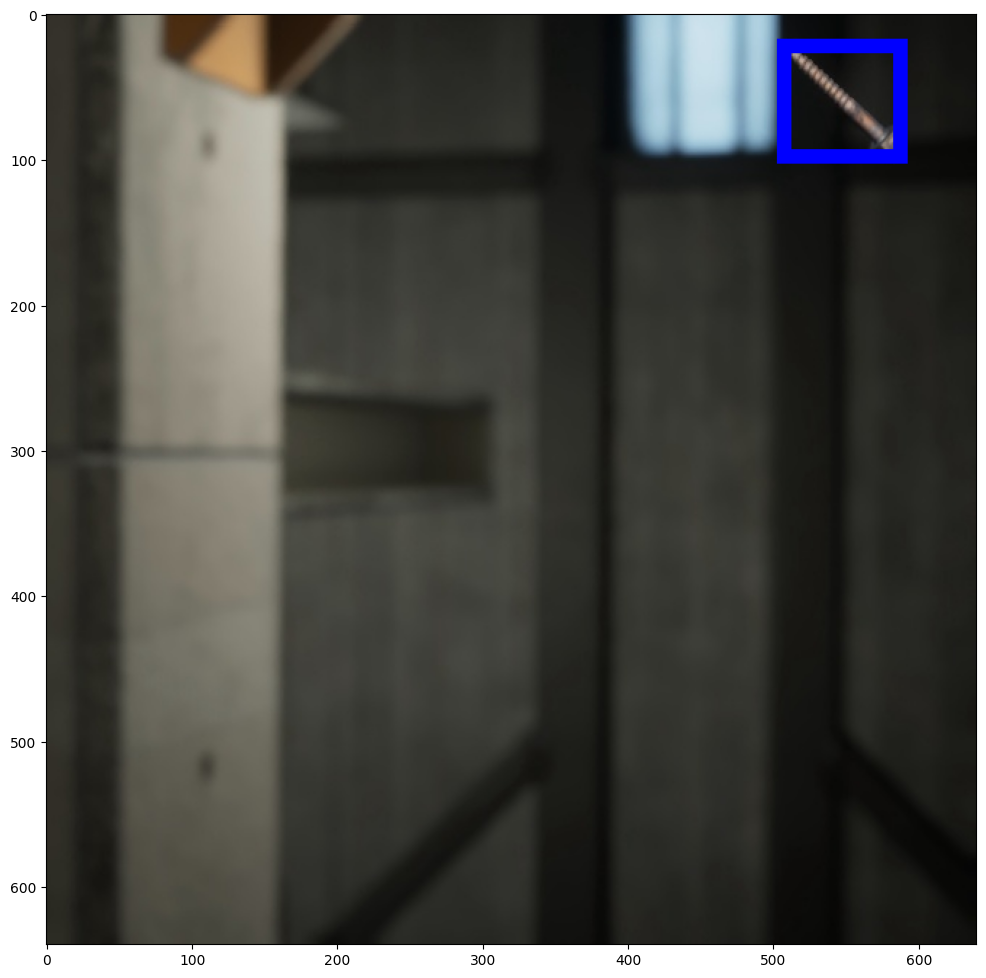

In [10]:
frame_number = "0112"
#get an annotation file
annotation_file = os.path.join(yolo_data_folder, "test/labels/{}.txt".format(frame_number))

#Get the corresponding image file
image_file = os.path.join(yolo_data_folder, "test/images/{}.jpg".format(frame_number))
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, np.loadtxt(annotation_file))

### Create new YAML file

In [28]:
# customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic


@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, "w") as f:
        f.write(cell.format(**globals()))

In [29]:
yaml_file = os.path.join(yolo_data_folder, "custom.yaml")

In [30]:
yolo_data_folder

'/media/ali/DATA/Projects/Storma/machine-learning-challenge/data/yolo/'

In [31]:
len(cat_names)

2

In [32]:
cat_names

['bolt', 'nut']

In [33]:
%%writetemplate {yaml_file}
train: {yolo_data_folder}/train/images
val: {yolo_data_folder}/val/images

nc: 2
names: ['bolt', 'nut']